In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

#Настраиваем генеративно-состязательную сеть (GAN) для генерации изображений из датасета MNIST 

# Загрузка данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
# Нормализуем ввод в диапазоне [-1, 1]
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
#Изменение формы данных для обработки сетью
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)

# Гиперпараметры 
latent_dim = 100 #размерность скрытого пространства
#Формы входов для генератора и дискриминатора
generator_input_shape = (latent_dim,)
discriminator_input_shape = (28, 28, 1)

In [2]:
# модель Генератора (принимает случайный шум и постепенно увеличивает размерность тензора, преобразуя его в изображение)
#тензор может иметь произвольное количество размерностей
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 128, input_shape=generator_input_shape))  # принимает шум, возвращает вектор
    model.add(layers.Reshape((7, 7, 128)))  # преобразоване с вектора в тензор размером 7 * 7 * 128 (вектор это частный случай тензора)
    model.add(layers.BatchNormalization())  # нормализация пакета
    model.add(layers.UpSampling2D())  # увеличение размерности в 2 раза
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))  # сверточный слой
    #повторная нормализация и увеличение размерности
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D())
    #финальный слой с одним фильтром и функцией активации tanh, который генерирует изображение
    model.add(layers.Conv2D(1, (5, 5), padding='same', activation='tanh'))
    return model

In [3]:
# Дискриминатор
#оценивает изображение и предсказывает вероятность того, что оно настоящее используя сверточные слои LeakyReLU и Dropout для извлечения признаков
def build_discriminator():
    model = models.Sequential()
    #сверточный слой с 64 фильтрами, ядро которых 5*5, с шагом 2*2 (принимает входное изображение)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=discriminator_input_shape))
    #LeakyReLU применяется для введения небольшой утечки в активации
    model.add(layers.LeakyReLU(alpha=0.2))
    # Слой исключения с вероятностью исключения 30 %, который
    # регуляризует данные, исключая случайно выбранные нейроны
    # во время обучения
    model.add(layers.Dropout(0.3))
    #еще один сверточный слой
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten()) # Выравнивание (тензор преобразует в вектор)
    #Финальный слой который возвращает вероятность того, что входное изображение является настоящим (1) или сгенерированным (0)
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [4]:
# Создание и компиляция моделей генератора, дискриминатора  и объединенной GAN

#Cоздание экземпляров генератора и дискриминатора
generator = build_generator()
discriminator = build_discriminator()

#Компиляция дискриминатора (с оптимизатором Adam, функцией потерь и точностью)
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False #замораживание дискриминатора

#Создается вход для GAN и пропускается через генератор.Затем результат подается на дискриминатор, создавая объединенную модель
gan_input = tf.keras.Input(shape=generator_input_shape)
x = generator(gan_input)
gan_output = discriminator(x)

#Компиляция GAN
gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')


In [5]:
# Вспомогательная функция для отображения сгенерированных изображений
def plot_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    #генерация случайного шума
    noise = np.random.normal(0, 1, size=(examples, latent_dim))
    #генерация изображения с использованием генератора
    generated_images = generator.predict(noise)
    #изменение формы и отображение изображений
    generated_images = generated_images.reshape(examples, 28, 28)

    #отображение изображений
    plt.figure(figsize=figsize)
    for i in range(10):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')


In [6]:
# Обучение GAN (генеративно - состязательной сети)
def train_GAN(epochs, batch_size):
    batch_count = train_images.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            # Создаем случайный шум для генератора
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            # Генерируем изображения с помощью генератора
            generated_images = generator.predict(noise)

            # Выбираем случайный набор настоящих изображений для дискриминатора
            image_batch = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

            # Создаем входные данные для дискриминатора
            X = np.concatenate([image_batch, generated_images])
            # Создаем метки для дискриминатора
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 1

            # Обучаем дискриминатор на входных данных и метках
            discriminator_loss = discriminator.train_on_batch(X, y_dis)

            # Создаем новый случайный шум для генератора
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            # Создаем метки для генератора
            y_gen = np.ones(batch_size)

            # Обучаем генератор на шуме и метках
            generator_loss = gan.train_on_batch(noise, y_gen)

        print(f"Epoch {epoch + 1}, D Loss: {discriminator_loss[0]}, G Loss: {generator_loss}")

        if (epoch + 1) % 10 == 0:
            plot_generated_images(generator, epoch + 1, latent_dim)

In [7]:
# Обучение GAN
train_GAN(epochs=5, batch_size=128)

# Сохранение генератора
generator.save('generator_model.h5')

# Сохранение дискриминатора
discriminator.save('discriminator_model.h5')

gan.save('gan_model.h5')

4/4 [==============================] - 0s 19ms/step


4/4 [==============================] - 0s 21ms/step
Epoch 1, D Loss: 0.6219626665115356, G Loss: 0.9085953831672668
4/4 [==============================] - 0s 19ms/step
Epoch 2, D Loss: 0.6388373374938965, G Loss: 0.7717812061309814
4/4 [==============================] - 0s 19ms/step
Epoch 3, D Loss: 0.632132887840271, G Loss: 0.8066040873527527
4/4 [==============================] - 0s 18ms/step
Epoch 4, D Loss: 0.6432400345802307, G Loss: 0.8983460664749146
4/4 [==============================] - 0s 24ms/step
Epoch 5, D Loss: 0.6443171501159668, G Loss: 0.9160459637641907


C:\Users\kasal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 14ms/step


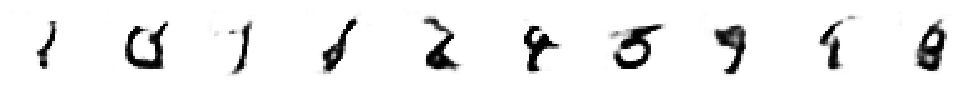

In [8]:
# Загрузка моделей
loaded_generator = tf.keras.models.load_model('generator_model.h5')
loaded_discriminator = tf.keras.models.load_model('discriminator_model.h5')
loaded_gan = tf.keras.models.load_model('gan_model.h5')
latent_dim = 100

plot_generated_images(loaded_generator, '', latent_dim)